# Affixal Rivalry between -ed and -y in English
This is an end of semester project for the class Advance Morphology at the University Paris Cite'. 

The aim of this project is to investigate the affixal rivalry between the ending -ed and -y in English. According to the paper by Nagano (2022), there exists a purely semantic affixal rivalry between these two endings in the denominalized adjectives, created from English concrete nouns. This project aims to investigate the findings from Nagano (2022), by using the distributional methodology.

There are two main experiments in this project. The first one is to compare the difference vectors between the two affixes to see if they are semantically comparable or not. The second experiment is to train a classifier on these difference vectors, then test the classifier on unseen data, in this case the data from UniMorph. There is an optional third experiment of using the semantic retrofitting method to see if the difference vectors can be improved.

In [1]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gensim.downloader as api


### Experiment 1: Compare difference vectors between -ed and -y

In [2]:
# Import the Google News 300 pre-trained Word2Vec model
wv = api.load('word2vec-google-news-300')


In [94]:
# Define a vectorize function
def vectorize(tokens):
    for token in tokens:
        if token in wv:
            return wv[token]
        else:
            return None

# Creating the dataframe for training data from Nagano (2022):
column_names = ['ROOT', 'DERIV', 'AFFIX']
train_data = pd.read_csv('nagano-data.tsv', sep='\t', names=column_names)
print(train_data)

# Vectorize the training data
train_data['ROOT_VECTOR'] = train_data['ROOT'].apply(lambda x: vectorize(x.split()))
train_data['DERIV_VECTOR'] = train_data['DERIV'].apply(lambda x: vectorize(x.split()))
train_data['AFFIX'] = train_data['AFFIX'].replace({'-ed': 0, '-y': 1})
print(train_data)

     ROOT    DERIV AFFIX
0     leg   legged   -ed
1     leg    leggy    -y
2    bone    boned   -ed
3    bone    boney    -y
4   price   priced   -ed
..    ...      ...   ...
71    oil     oily    -y
72  spice   spiced   -ed
73  spice    spicy    -y
74  sugar  sugared   -ed
75  sugar   sugary    -y

[76 rows x 3 columns]
     ROOT    DERIV  AFFIX                                        ROOT_VECTOR  \
0     leg   legged      0  [0.00090789795, 0.12011719, 0.021972656, -0.27...   
1     leg    leggy      1  [0.00090789795, 0.12011719, 0.021972656, -0.27...   
2    bone    boned      0  [-0.21191406, 0.049072266, -0.11328125, -0.032...   
3    bone    boney      1  [-0.21191406, 0.049072266, -0.11328125, -0.032...   
4   price   priced      0  [0.14160156, -0.02709961, -0.18457031, 0.17480...   
..    ...      ...    ...                                                ...   
71    oil     oily      1  [-0.13964844, 0.06225586, -0.27929688, 0.06396...   
72  spice   spiced      0  [-0.016357

In [95]:

# Define a function to calculate the difference vector between the root and the derivational form:
def difference_vector(v1, v2):
    return np.subtract(v1, v2)

# Defining the function to calculate the cosine similarity between two vectors:
def cosine_similarity(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

# Let's calculate the average between 2 random words:
import random

ave_similarity = []
for i in range(100000): # Google News 300 has 3 million words, we can just try randomly 100000 times
    x = random.choice(wv.index_to_key)
    y = random.choice(wv.index_to_key)
    similarity = wv.similarity(x,y)
    ave_similarity.append(similarity)

print(f"The average similarity between 2 random words is: {np.mean(ave_similarity)}")


The average similarity between 2 random words is: 0.13087069988250732


In [96]:
# Calculating the difference vector between the root and the derivational form for each word:
train_data['DIFFERENCE_VECTOR'] = train_data.apply(lambda x: difference_vector(x['ROOT_VECTOR'], x['DERIV_VECTOR']), axis=1)

# Separate the data into two groups: -ed and -y:
train_data_ed = train_data[train_data['AFFIX'] == 0].reset_index(drop=True)
train_data_y = train_data[train_data['AFFIX'] == 1].reset_index(drop=True)

# Calculating the cosine similarity between the difference vector of -ed and -y for each word:
new_train_data = pd.concat([train_data_ed['ROOT'], train_data_ed['DIFFERENCE_VECTOR']], axis=1)
new_train_data = new_train_data.rename(columns={'DIFFERENCE_VECTOR': 'DIFFERENCE_VECTOR_ed'})
new_train_data = pd.concat([new_train_data, train_data_y['DIFFERENCE_VECTOR']], axis=1)
new_train_data = new_train_data.rename(columns={'DIFFERENCE_VECTOR': 'DIFFERENCE_VECTOR_y'})
new_train_data['COSINE_SIMILARITY'] = new_train_data.apply(lambda x: cosine_similarity(x['DIFFERENCE_VECTOR_ed'], x['DIFFERENCE_VECTOR_y']), axis=1)
new_train_data = new_train_data.drop(['DIFFERENCE_VECTOR_ed', 'DIFFERENCE_VECTOR_y'], axis=1)
print(new_train_data)
print(f"The average similarity between the two affixes is: {new_train_data['COSINE_SIMILARITY'].mean()}")

       ROOT  COSINE_SIMILARITY
0       leg           0.526988
1      bone           0.602122
2     price           0.537156
3       wit           0.264876
4     curve           0.628152
5      head           0.354714
6     brain           0.603593
7     cheek           0.448141
8   feather           0.641470
9      hand           0.227643
10     head           0.354714
11      hip           0.482956
12    mouth           0.506514
13     nose           0.364511
14     skin           0.517622
15    tooth           0.620628
16     edge           0.395138
17     loft           0.324167
18     room           0.246554
19    shape           0.319353
20    taste           0.323992
21     fish           0.202100
22     leaf           0.354984
23     rock           0.445634
24     sand           0.314394
25    stone           0.345706
26    water           0.352573
27      air           0.181804
28    cloud           0.606249
29     dust           0.459283
30      ice           0.322265
31     m

### Experiment 2: Train a classifier on the training data from Nagano (2022) to predict the affixes of the UniMorph data.

In [99]:
# Importing the UniMorph dataset
column_names = ['ROOT', 'DERIV', 'PROCESS', 'AFFIX']
data = pd.read_csv('UniMorph-Eng/eng/eng.derivations.tsv', sep='\t', names = column_names)

# We only look at N:ADJ and -ed; -y
data = data[(data['PROCESS'] == 'N:ADJ') & ((data['AFFIX'] == '-ed') | (data['AFFIX'] == '-y'))]
data = data.drop(['PROCESS',], axis=1)
data = data.reset_index(drop=True)
data['AFFIX'] = data['AFFIX'].replace({'-ed': 0, '-y': 1})

print(data) # data is a dataframe of 4192 examples, many of which may not have a corresponding vector in the Word2Vec model


              ROOT          DERIV  AFFIX
0          abandon      abandoned      0
1           abatis       abatised      0
2            abort        aborted      0
3         abstract     abstracted      0
4             crag         craggy      1
...            ...            ...    ...
4187          wuss          wussy      1
4188  significator  significatory      1
4189    combinator    combinatory      1
4190          hock         hocked      0
4191       lattice       latticed      0

[4192 rows x 3 columns]


In [100]:
# Vectorize the data
data['ROOT_VECTOR'] = data['ROOT'].apply(lambda x: vectorize(x.split()))

# Process the train and test data:
clf_train_data = train_data.drop(['ROOT', 'DERIV', 'DERIV_VECTOR', 'DIFFERENCE_VECTOR'], axis=1) # Train data is [LABEL, ROOT_VECTOR]
clf_data = data.drop(['ROOT', 'DERIV'], axis = 1) # Test data is [LABEL, ROOT_VECTOR]
clf_data = clf_data[clf_data['ROOT_VECTOR'].apply(lambda x: x is not None)] # Remove the rows with None values
clf_data = clf_data.reset_index(drop=True)

train_examples = [(x, y) for x, y in zip(clf_train_data['ROOT_VECTOR'], clf_train_data['AFFIX'])] # Train examples is [(ROOT_VECTOR, LABEL)]
test_examples = [(x,y) for x, y  in zip(clf_data['ROOT_VECTOR'], clf_data['AFFIX'])]         # Test examples is [(ROOT_VECTOR, LABEL)]

# The ratio of -ed and -y in the test data:
clf_data_ed = clf_data[clf_data['AFFIX'] == 0].reset_index(drop=True)
clf_data_y = clf_data[clf_data['AFFIX'] == 1].reset_index(drop=True)
print(f"The ratio of -ed in the test data is: {len(clf_data_ed) / len(clf_data): .2%}")
print(f"The ratio of -y in the test data is: {len(clf_data_y) / len(clf_data): .2%}")

The ratio of -ed in the test data is:  42.92%
The ratio of -y in the test data is:  57.08%


In [101]:
# Create a neural network for classification:
# Here we are going to use a simple neural network with 1 hidden layer
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.manual_seed(42)

# Define the neural network:
# This is a general architecture of a feedforward neural network with 1 hidden layer in PyTorch.
class AffixClassifier(nn.Module):
    # Here we create just a simple NN with 1 hidden layer:
    def __init__(self, nb_classes = 2, vector_dim = 300, hidden_layer_size = 128):
        """ - vector_dim is the size of the vectors representing the objects to classify, here is 300 
            - hidden_layer_size is 128, the size of the hidden layer
        """
        super(AffixClassifier, self).__init__()
        self.linear_1 = nn.Linear(vector_dim, hidden_layer_size) # The input is a vector of 300 dimensions
        self.linear_2 = nn.Linear(hidden_layer_size, nb_classes)   # The output is a vector of 2 dimensions
    
    def forward(self, X):
        """
        Input : X batch of inputs : ( shape (b, d) )
                with b is the size of the batch (it does not have to be constant)
        Output : log probabilities (shape (b, nb_classes) )
        """
        out = self.linear_1(X) # Forward to hidden layer [b, d] -> [b, hidden_layer_size]
        out = F.relu(out) # Apply ReLU activation function 
        out = self.linear_2(out) # Forward to output layer [b, hidden_layer_size] -> [b, nb_classes]
        return F.log_softmax(out, dim=1) # Apply log softmax activation function to the batch                          
               

Loss on training set at epoch 0 : 7.636295
Loss on training set at epoch 1 : 7.645344
Loss on training set at epoch 2 : 7.645167
Loss on training set at epoch 3 : 7.640953
Loss on training set at epoch 4 : 7.641720
Loss on training set at epoch 5 : 7.639125
Loss on training set at epoch 6 : 7.639636
Loss on training set at epoch 7 : 7.638994
Loss on training set at epoch 8 : 7.636650
Loss on training set at epoch 9 : 7.642851
Loss on training set at epoch 10 : 7.641470
Loss on training set at epoch 11 : 7.641047
Loss on training set at epoch 12 : 7.638055
Loss on training set at epoch 13 : 7.639291
Loss on training set at epoch 14 : 7.640546
Loss on training set at epoch 15 : 7.640443
Loss on training set at epoch 16 : 7.641477
Loss on training set at epoch 17 : 7.640553
Loss on training set at epoch 18 : 7.637527
Loss on training set at epoch 19 : 7.642396
Loss on training set at epoch 20 : 7.643546
Loss on training set at epoch 21 : 7.638123
Loss on training set at epoch 22 : 7.64469

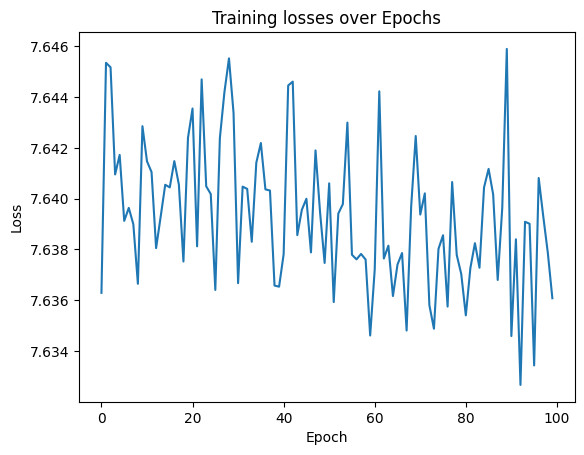

In [102]:
# Initialize the classifier:
classifier = AffixClassifier() 

# Define the loss function and optimizer:
loss_function = nn.NLLLoss() # Negative Log Likelihood Loss
optimizer = optim.SGD(classifier.parameters(), lr=0.01) # Stochastic Gradient Descent

# Train the classifier:
from random import shuffle
train_losses = []
NB_EPOCHS = 100
BATCH_SIZE = 7 # There are 76 examples in the training data, so we can use a batch size of 7

# loop on epochs
best_loss = float('inf')
best_epoch = 0
for epoch in range(NB_EPOCHS):
    epoch_loss = 0
    
    # shuffle data
    shuffle(train_examples)
    i = 0
    while i < len(train_examples):
        
        batch = train_examples[i: i+BATCH_SIZE]
        i += BATCH_SIZE
        
        contexts, targets = zip(*batch)

        # Step 1. Prepare the inputs to be passed to the model 
        input_tensor = torch.from_numpy(np.array(contexts)) # [BATCH_SIZE, VECTOR_DIM]
        gold_labels = torch.tensor(targets, dtype=torch.long)   # [BATCH_SIZE]
        
        # Step 2. Reset gradients to 0
        classifier.zero_grad()
        
        # Step 3. Forward propagation
        classifier(input_tensor)
        
        # Step 4. Compute the loss and add training loss to the epoch loss
        loss = loss_function(classifier(input_tensor), gold_labels)
        epoch_loss += loss.item()
        
        # Step 5. Backward propagation
        loss.backward()
        
        # Step 6. Update the parameters
        optimizer.step()        
           
    # end of handling of this batch
    print("Loss on training set at epoch %d : %f" %(epoch, epoch_loss))
    train_losses.append(epoch_loss)
# Plot the training losses
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training losses over Epochs")
plt.show()


In [103]:
# Test the classifier:
with torch.no_grad():
    # Forward on the test set:
    test_contexts, test_targets = zip(*test_examples)
    test_input_tensor = torch.from_numpy(np.array(test_contexts))
    test_gold_labels = torch.tensor(test_targets, dtype=torch.long)
    log_probs = classifier(test_input_tensor)
    
    # Compute the accuracy:
    pred_labels = torch.argmax(log_probs, dim=1)
    accuracy = torch.sum(pred_labels == test_gold_labels).item() / len(test_gold_labels)
    print(f"Accuracy on test set after training on the train data for {NB_EPOCHS} epochs with 10 folds and shuffled data: {accuracy:.3%}")

Accuracy on test set after training on the train data for 100 epochs with 10 folds and shuffled data: 49.146%


### Experiment 3: Apply semantic retrofitting to the training vectors to see if the results improve or not.
Semantic retrofitting is a method to improve the quality of the word vectors by using the semantic information (synonyms, antonyms, hyper/hyponyms) from a lexicon. 

In this experiment, we will use the retrofitting method from Faruqui et al. (2015) and the WordNet lexicon to improve the quality of the word vectors from the training data. The WordNet lexicon provides the semantic information for the words, and then use the retrofitting method to create a new word vector based on the old word vector and the "neighbors" of the word. The idea of retrofitting is to have a new word vector that is close (has a better cosine similarity) to the old word vector, but is also closer to the neighbors of the word. This new word vector is then said to be capturing the semantic information of the word better than the purely distributional word vector.

Then we will recalculate the difference vectors to see if there are improvements or not, and if these improvements are significant.

In [104]:
# We implement the retrofitting algorithm of Faruqui et al. (2015):
import math
import re
from copy import deepcopy
import sys
import gzip
from nltk.corpus import wordnet as wn

# Preprocessing the data:
isNumber = re.compile(r'\d+.*')
def norm_word(word):
  if isNumber.search(word.lower()):
    return '---num---'
  elif re.sub(r'\W+', '', word) == '':
    return '---punc---'
  else:
    return word.lower()

# Read all the word vectors and normalize them:
def read_word_vecs(filename):
  wordVectors = {}
  if filename.endswith('.gz'): fileObject = gzip.open(filename, 'r')
  else: fileObject = open(filename, 'r')
  
  for line in fileObject:
    line = line.strip().lower()
    word = line.split()[0]
    wordVectors[word] = np.zeros(len(line.split())-1, dtype=float)
    for index, vecVal in enumerate(line.split()[1:]):
      wordVectors[word][index] = float(vecVal)
    ''' normalize weight vector '''
    wordVectors[word] /= math.sqrt((wordVectors[word]**2).sum() + 1e-6)
    
  sys.stderr.write("Vectors read from: "+filename+" \n")
  return wordVectors

# Read lexicon as a dictionary:
def read_lexicon(filename):
  lexicon = {}
  if filename.endswith('.gz'): fileObject = gzip.open(filename, 'r')
  else: fileObject = open(filename, 'r')
  
  for line in fileObject:
    words = line.lower().strip().split()
    lexicon[norm_word(words[0])] = [norm_word(word) for word in words[1:]]
  return lexicon

# Retrofit word vectors to a lexicon:
def retrofit(wordVecs, lexicon, numIters): # wordVecs is a dictionary
  newWordVecs = deepcopy(wordVecs)
  wvVocab = set(newWordVecs.keys())
  loopVocab = wvVocab.intersection(set(lexicon.keys()))
  for it in range(numIters):
    # loop through every node also in ontology (else just use data estimate)
    for word in loopVocab:
      wordNeighbours = set(lexicon[word]).intersection(wvVocab)
      numNeighbours = len(wordNeighbours)
      #no neighbours, pass - use data estimate
      if numNeighbours == 0:
        continue
      # the weight of the old vector is alpha*numNeighbours
      newVec = wordVecs[word] * numNeighbours
      # loop over neighbours and add to new vector (currently with weight beta)
      for ppWord in wordNeighbours:
        newVec += newWordVecs[ppWord] 
      newWordVecs[word] = newVec/(numNeighbours) 
  return newWordVecs

In [105]:
# Read the lexicon. We can use NLTK WordNet.
lexicon = {}
# The idea is to create a dictionary where the keys are the words in the corpus
# and the values are the words that are related to the key word from the WordNet.
for synset in wn.all_synsets():
    for lemma in synset.lemmas():
        word = lemma.name()
        if word not in lexicon:
            lexicon[word] = []
        for related_synset in synset.hyponyms() + synset.hypernyms() + synset.part_meronyms() + synset.part_holonyms() + synset.member_holonyms() + synset.member_meronyms():
            for related_lemma in related_synset.lemmas():
                related_word = related_lemma.name()
                if related_word != word:
                    lexicon[word].append(related_word)

In [106]:
# Create a word vector dictionary using train data:
root_dict = pd.concat([train_data_ed['ROOT'], train_data_ed['ROOT_VECTOR']], axis = 1, keys = ['ROOT', 'ROOT_VECTOR'])
ed_dict = pd.concat([train_data_ed['DERIV'], train_data_ed['DERIV_VECTOR']], axis = 1, keys = ['DERIV_ed', 'DERIV_VECTOR'])
y_dict = pd.concat([train_data_y['DERIV'], train_data_y['DERIV_VECTOR']], axis = 1, keys = ['DERIV_y', 'DERIV_VECTOR'])

old_root_vecs = root_dict.set_index('ROOT')['ROOT_VECTOR'].to_dict()
old_ed_vecs = ed_dict.set_index('DERIV_ed')['DERIV_VECTOR'].to_dict()
old_y_vecs = y_dict.set_index('DERIV_y')['DERIV_VECTOR'].to_dict()

# Retrofit the word vectors:
new_root_vecs = retrofit(old_root_vecs, lexicon, 10)
new_ed_vecs = retrofit(old_ed_vecs, lexicon, 10)
new_y_vecs = retrofit(old_y_vecs, lexicon, 10)


In [119]:
# Compare some of the word vectors:
print(f"Cosine similarity between old 'leggy' and new 'leggy' vector is: {cosine_similarity(old_y_vecs['leggy'], new_y_vecs['leggy'])}")
print(f"Cosine similarity between old 'witted' and new 'witted' vector is: {cosine_similarity(old_ed_vecs['witted'], new_ed_vecs['witted'])}")
print(f"Cosine similarity between old 'cheek' and the new 'cheek' vector is: {cosine_similarity(old_root_vecs['cheek'], new_root_vecs['cheek'])}")
print("Not all vectors were changed, but some have been changed minutely.")

# Create new dataframes with the new word vectors and calculate the cosine similarity:
new_root_dict = pd.DataFrame(list(new_root_vecs.items()), columns = ['ROOT', 'ROOT_VECTOR'])
new_ed_dict = pd.DataFrame(list(new_ed_vecs.items()), columns = ['DERIV_ed', 'DERIV_VECTOR_ed'])
new_y_dict = pd.DataFrame(list(new_y_vecs.items()), columns = ['DERIV_y', 'DERIV_VECTOR_y'])
new_dict = pd.concat([new_root_dict, new_ed_dict, new_y_dict], axis = 1)

new_dict['DIFFERENCE_VECTOR_ed'] = new_dict['DERIV_VECTOR_ed'] - new_dict['ROOT_VECTOR']
new_dict['DIFFERENCE_VECTOR_y'] = new_dict['DERIV_VECTOR_y'] - new_dict['ROOT_VECTOR']

new_dict["COSINE_SIMILARITY"] = new_dict.apply(lambda x: cosine_similarity(x['DIFFERENCE_VECTOR_ed'], x['DIFFERENCE_VECTOR_y']), axis = 1)
new_dict.drop(['ROOT_VECTOR', 'DERIV_VECTOR_ed', 'DERIV_VECTOR_y','DIFFERENCE_VECTOR_ed', 'DIFFERENCE_VECTOR_y'], axis = 1, inplace = True)

new_dict['OLD_COSINE_SIMILARITY'] = new_train_data['COSINE_SIMILARITY']

# Presenting the results:
print('\n')
print("The new dataframe with the new word vectors and the cosine similarity compared to old similarity is: ")
print(new_dict.head())

print('\n')
print(f"The average similarity between the two retrofitted vectors is: {new_dict['COSINE_SIMILARITY'].mean()}")
print(f"The average similarity is increased by: {new_dict['COSINE_SIMILARITY'].mean() - new_train_data['COSINE_SIMILARITY'].mean(): .4f}, which is a very small increase. \nHowever, we can see some vectors have significantly and positively changed, such as 'bone' and 'curve', while some is changed negatively, such as 'dress'.")
print("Therefore, we can assume that the semantic retrofitting has improved the word vectors. \nThus the affixal processes are semantically similar.")

print('\n')
print("These are all 30 affected roots:")
new_df = new_dict[new_dict['COSINE_SIMILARITY'] != new_dict['OLD_COSINE_SIMILARITY']].reset_index(drop = True)

print(new_df)


Cosine similarity between old 'leggy' and new 'leggy' vector is: 0.9999999403953552
Cosine similarity between old 'witted' and new 'witted' vector is: 1.0
Cosine similarity between old 'cheek' and the new 'cheek' vector is: 1.0
Not all vectors were changed, but some have been changed minutely.


The new dataframe with the new word vectors and the cosine similarity compared to old similarity is: 
    ROOT DERIV_ed DERIV_y  COSINE_SIMILARITY  OLD_COSINE_SIMILARITY
0    leg   legged   leggy           0.526988               0.526988
1   bone    boned   boney           0.998281               0.602122
2  price   priced  pricey           0.537156               0.537156
3    wit   witted   witty           0.264876               0.264876
4  curve   curved   curvy           0.997423               0.628152


The average similarity between the two retrofitted vectors is: 0.4950392544269562
The average similarity is increased by:  0.0788, which is a very small increase. 
However, we can see some ve

## Discussion:
Because the accuracy in the 2nd experiment is much lower than the baseline of predicting the most frequent affix, we will look into this problem from several perspective:
- The classifier might be learning too much unnecessary details from the train set, and thus cannot generalize well to the test set. We can implement an early stopping mechanism to stop the training when the accuracy on the validation set stops improving.
- The training set is simply too small for the classifier to capture anything, even after training for 100 epochs and doing 10 folds. To check, we can try to train on the larger set and predict on the smaller set to see if the accuracy improves.
- The training and the test sets are too different.
- The classifier is not efficient enough to capture the semantic information from the difference vectors. To check, we can test the same classifier on another task.
- The two affixes are indeed rivals.



In [108]:
# We implement an early stopping mechanism to stop the training when the validation loss is not decreasing anymore.
# Initialize the classifier:
classifier = AffixClassifier() 

# Define the loss function and optimizer:
loss_function = nn.NLLLoss() # Negative Log Likelihood Loss
optimizer = optim.SGD(classifier.parameters(), lr=0.01) # Stochastic Gradient Descent

# Train the classifier:
from random import shuffle
train_losses = []
NB_EPOCHS = 100
BATCH_SIZE = 7 # There are 76 examples in the training data, so we can use a batch size of 7

# loop on epochs
best_loss = float('inf')
best_epoch = 0
for epoch in range(NB_EPOCHS):
    epoch_loss = 0
    
    # shuffle data
    shuffle(train_examples)
    i = 0
    while i < len(train_examples):
        
        batch = train_examples[i: i+BATCH_SIZE]
        i += BATCH_SIZE
        
        contexts, targets = zip(*batch)

        # Step 1. Prepare the inputs to be passed to the model 
        input_tensor = torch.from_numpy(np.array(contexts)) # [BATCH_SIZE, VECTOR_DIM]
        gold_labels = torch.tensor(targets, dtype=torch.long)   # [BATCH_SIZE]
        
        # Step 2. Reset gradients to 0
        classifier.zero_grad()
        
        # Step 3. Forward propagation
        classifier(input_tensor)
        
        # Step 4. Compute the loss and add training loss to the epoch loss
        loss = loss_function(classifier(input_tensor), gold_labels)
        epoch_loss += loss.item()
        
        # Step 5. Backward propagation
        loss.backward()
        
        # Step 6. Update the parameters
        optimizer.step()        
    # Step 7: Implement early stopping:
    with torch.no_grad():
        test_contexts, test_targets = zip(*test_examples)
        test_input_tensor = torch.from_numpy(np.array(test_contexts))
        test_gold_labels = torch.tensor(test_targets, dtype=torch.long)
        log_probs = classifier(test_input_tensor)    
        
        loss = loss_function(log_probs, test_gold_labels) # Compute loss on dev set
        dev_loss = loss.item()
        print(f"Best loss: {best_loss:.4}")
        print(f"Dev loss: {dev_loss:.4} at epoch {epoch}")
            
    if dev_loss < best_loss: # If the loss on the dev set is lower than the best loss
        best_loss = dev_loss # Update the best loss
        best_epoch = epoch # Update the best epoch
    else: # If the loss on the dev set is higher than the best loss
        print("Performance decreases, stopping training")
        print(f"Best epoch: {best_epoch}, best loss: {best_loss:.4}")
        break # Stop training     
               
    # end of handling of this batch
    print("Loss on training set at epoch %d : %f" %(epoch, epoch_loss))
    train_losses.append(epoch_loss)




Best loss: inf
Dev loss: 0.6878 at epoch 0
Loss on training set at epoch 0 : 7.647481
Best loss: 0.6878
Dev loss: 0.6881 at epoch 1
Performance decreases, stopping training
Best epoch: 0, best loss: 0.6878


In [109]:
# Evaluate the classifier on the test set:
# Test the classifier:
with torch.no_grad():
    # Forward on the test set:
    test_contexts, test_targets = zip(*test_examples)
    test_input_tensor = torch.from_numpy(np.array(test_contexts))
    test_gold_labels = torch.tensor(test_targets, dtype=torch.long)
    log_probs = classifier(test_input_tensor)
    
    # Compute the accuracy:
    pred_labels = torch.argmax(log_probs, dim=1)
    accuracy = torch.sum(pred_labels == test_gold_labels).item() / len(test_gold_labels)
    print(f"Accuracy on test set after training on the train data for {best_epoch} epochs with 10 folds and shuffled data: {accuracy:.3%}")

Accuracy on test set after training on the train data for 0 epochs with 10 folds and shuffled data: 56.662%


Best loss: inf
Dev loss: 0.6549 at epoch 0
Loss on training set at epoch 0 : 366.725558
Best loss: 0.6549
Dev loss: 0.6019 at epoch 1
Loss on training set at epoch 1 : 343.890053
Best loss: 0.6019
Dev loss: 0.5541 at epoch 2
Loss on training set at epoch 2 : 315.012588
Best loss: 0.5541
Dev loss: 0.5305 at epoch 3
Loss on training set at epoch 3 : 296.800249
Best loss: 0.5305
Dev loss: 0.516 at epoch 4
Loss on training set at epoch 4 : 287.224386
Best loss: 0.516
Dev loss: 0.5074 at epoch 5
Loss on training set at epoch 5 : 281.110474
Best loss: 0.5074
Dev loss: 0.5001 at epoch 6
Loss on training set at epoch 6 : 276.879511
Best loss: 0.5001
Dev loss: 0.493 at epoch 7
Loss on training set at epoch 7 : 273.677232
Best loss: 0.493
Dev loss: 0.4882 at epoch 8
Loss on training set at epoch 8 : 270.928533
Best loss: 0.4882
Dev loss: 0.4852 at epoch 9
Loss on training set at epoch 9 : 268.273714


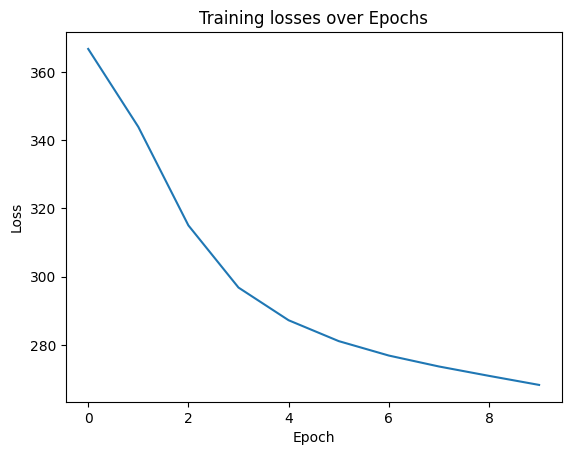

In [110]:
# Redo experiment 2 with training data = UniMorph data:
# Initialize the classifier:
classifier = AffixClassifier() 

# Define the loss function and optimizer:
loss_function = nn.NLLLoss() # Negative Log Likelihood Loss
optimizer = optim.SGD(classifier.parameters(), lr=0.01) # Stochastic Gradient Descent

# Train the classifier:
from random import shuffle
train_losses = []
NB_EPOCHS = 10
BATCH_SIZE = 7 # There are 76 examples in the training data, so we can use a batch size of 7

# loop on epochs
best_loss = float('inf')
best_epoch = 0
for epoch in range(NB_EPOCHS):
    epoch_loss = 0
    
    # shuffle data
    shuffle(test_examples)
    i = 0
    while i < len(test_examples):
        
        batch = test_examples[i: i+BATCH_SIZE]
        i += BATCH_SIZE
        
        contexts, targets = zip(*batch)

        # Step 1. Prepare the inputs to be passed to the model 
        input_tensor = torch.from_numpy(np.array(contexts)) # [BATCH_SIZE, VECTOR_DIM]
        gold_labels = torch.tensor(targets, dtype=torch.long)   # [BATCH_SIZE]
        
        # Step 2. Reset gradients to 0
        classifier.zero_grad()
        
        # Step 3. Forward propagation
        classifier(input_tensor)
        
        # Step 4. Compute the loss and add training loss to the epoch loss
        loss = loss_function(classifier(input_tensor), gold_labels)
        epoch_loss += loss.item()
        
        # Step 5. Backward propagation
        loss.backward()
        
        # Step 6. Update the parameters
        optimizer.step()        
    
        # Step 7: Implement early stopping:
    with torch.no_grad():
        test_contexts, test_targets = zip(*test_examples)
        test_input_tensor = torch.from_numpy(np.array(test_contexts))
        test_gold_labels = torch.tensor(test_targets, dtype=torch.long)
        log_probs = classifier(test_input_tensor)    
        
        loss = loss_function(log_probs, test_gold_labels) # Compute loss on dev set
        dev_loss = loss.item()
        print(f"Best loss: {best_loss:.4}")
        print(f"Dev loss: {dev_loss:.4} at epoch {epoch}")
            
    if dev_loss < best_loss: # If the loss on the dev set is lower than the best loss
        best_loss = dev_loss # Update the best loss
        best_epoch = epoch # Update the best epoch
    else: # If the loss on the dev set is higher than the best loss
        print("Performance decreases, stopping training")
        print(f"Best epoch: {best_epoch}, best loss: {best_loss:.4}")
        break # Stop training    
            
    # end of handling of this batch
    print("Loss on training set at epoch %d : %f" %(epoch, epoch_loss))
    train_losses.append(epoch_loss)
# Plot the training losses
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training losses over Epochs")
plt.show()


In [111]:
# Test the classifier on Nagano data:
with torch.no_grad():
    # Forward on the test set:
    test_contexts, test_targets = zip(*train_examples)
    test_input_tensor = torch.from_numpy(np.array(test_contexts))
    test_gold_labels = torch.tensor(test_targets, dtype=torch.long)
    log_probs = classifier(test_input_tensor)
    
    # Compute the accuracy:
    pred_labels = torch.argmax(log_probs, dim=1)
    accuracy = torch.sum(pred_labels == test_gold_labels).item() / len(test_gold_labels)
    print(f"The predicted labels are: {pred_labels}")
    print(f"The gold labels are: {test_gold_labels}")
    print(f"Accuracy on test set after training on the train data for 10 epochs with batch size of 7 and shuffled data: {accuracy:.3%}")

The predicted labels are: tensor([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1])
The gold labels are: tensor([0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1,
        0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
        0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1,
        1, 1, 0, 1])
Accuracy on test set after training on the train data for 10 epochs with batch size of 7 and shuffled data: 50.000%


The classifier trained on the larger UniMorph dataset and tested on Nagano's is at exactly 50%, which is the baseline for this dataset. The fact that the result of this reversal is exactly the same as the baseline suggests that the smaller training data and the classifier is not to be blamed for the low accuracy. The two affixes are indeed rivals.

In [112]:

# Importing the UniMorph dataset
column_names = ['ROOT', 'DERIV', 'PROCESS', 'AFFIX']
data = pd.read_csv('UniMorph-Eng/eng/eng.derivations.tsv', sep='\t', names = column_names)

# We only look at N:N and -s:
data = data[(data['PROCESS'] == 'N:N') & ((data['AFFIX'] == '-s'))]
data = data.drop(['PROCESS',], axis=1) # Remove the PROCESS column
data = data.reset_index(drop=True) # Reset the index
data['AFFIX'] = data['AFFIX'].replace({'-s': 1}) # Replace -s with 1
data['ROOT_LABEL'] = data['AFFIX'].replace({1: 0}) # Create a new column with the root label
data = data[data['ROOT'].str.len() > 1].reset_index(drop=True) # Remove all roots with length of 1

# Split the data into singular and plural:
sg_data = data[data['ROOT_LABEL'] == 0]
pl_data = data[data['AFFIX'] == 1]

# Remove the columns we don't need:
sg_data = sg_data.drop(['DERIV', 'AFFIX'], axis=1)
sg_data = sg_data.rename(columns = {'ROOT_LABEL' : 'AFFIX'})
pl_data = pl_data.drop(['ROOT', 'ROOT_LABEL'], axis=1)
pl_data = pl_data.rename(columns={'DERIV': 'ROOT'})
new_data = pd.concat([sg_data, pl_data], axis=0) # This dataset has 2 columns: ROOT and AFFIX

print(f"The ratio of singular in the dataset is: {sg_data.shape[0] / new_data.shape[0]:.3%}")
print(f"The ratio of plural in the dataset is: {pl_data.shape[0] / new_data.shape[0]:.3%}")

# Vectorize the data:
new_data['VECTOR'] = new_data.apply(lambda x: vectorize(x['ROOT']), axis = 1)
new_data = new_data.dropna().reset_index(drop = True) # Remove all rows with NaN values
print(new_data)
new_data = new_data.drop(['ROOT'], axis=1) # Remove the ROOT column


The ratio of singular in the dataset is: 50.000%
The ratio of plural in the dataset is: 50.000%
              ROOT  AFFIX                                             VECTOR
0          bollock      0  [-0.203125, 0.053222656, 0.109375, 0.21777344,...
1              her      0  [-0.28710938, 0.29296875, -0.044677734, 0.0383...
2              our      0  [-0.1640625, 0.08203125, 0.028198242, 0.106445...
3             cord      0  [-0.20800781, 0.034179688, 0.025756836, 0.1796...
4             need      0  [-0.013977051, -0.02722168, -0.05493164, 0.175...
..             ...    ...                                                ...
541      trimmings      1  [-0.33789062, 0.19824219, -0.296875, 0.1484375...
542  Massachusetts      1  [-0.12060547, 0.049804688, -0.03515625, 0.2968...
543          Owens      1  [-0.27148438, 0.22460938, 0.12890625, 0.011474...
544       Thwaites      1  [-0.2421875, 0.14550781, 0.026855469, 0.007598...
545       bulwarks      1  [-0.203125, 0.053222656, 0.109

In [113]:
new_data = new_data.sample(frac=1).reset_index(drop=True)

# Split the data into train and test sets:
train_set = new_data[:int(len(new_data)*0.8)]
test_set = new_data[int(len(new_data)*0.8):]

train_set_1 = train_set[train_set['AFFIX'] == 1]
train_set_0 = train_set[train_set['AFFIX'] == 0]
test_set_1 = test_set[test_set['AFFIX'] == 1]
test_set_0 = test_set[test_set['AFFIX'] == 0]
print(f"The ratio of singular in the train set is: {train_set_0.shape[0] / train_set.shape[0]:.3%}")
print(f"The ratio of plural in the train set is: {train_set_1.shape[0] / train_set.shape[0]:.3%}")
print(f"The ratio of singular in the test set is: {test_set_0.shape[0] / test_set.shape[0]:.3%}")
print(f"The ratio of plural in the test set is: {test_set_1.shape[0] / test_set.shape[0]:.3%}")

train_examples = [(x, y) for x, y in zip(train_set['VECTOR'], train_set['AFFIX'])]
test_examples = [(x, y) for x, y in zip(test_set['VECTOR'], test_set['AFFIX'])]


The ratio of singular in the train set is: 49.083%
The ratio of plural in the train set is: 50.917%
The ratio of singular in the test set is: 53.636%
The ratio of plural in the test set is: 46.364%


Best loss: inf
Dev loss: 0.6987 at epoch 0
Loss on training set at epoch 0 : 43.903317
Best loss: 0.6987
Dev loss: 0.6973 at epoch 1
Loss on training set at epoch 1 : 43.799863
Best loss: 0.6973
Dev loss: 0.6967 at epoch 2
Loss on training set at epoch 2 : 43.715632
Best loss: 0.6967
Dev loss: 0.698 at epoch 3
Performance decreases, stopping training
Best epoch: 2, best loss: 0.6967


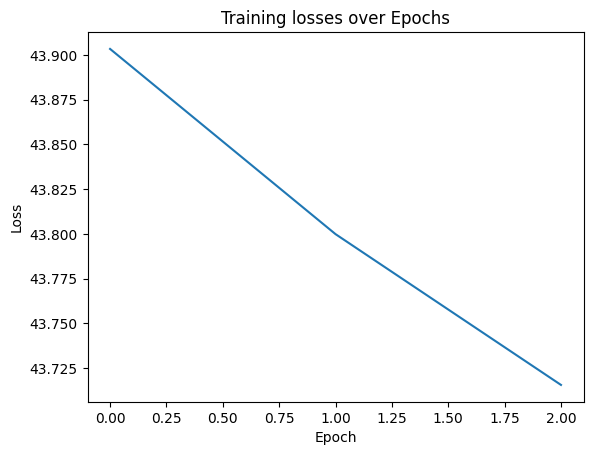

In [114]:
# Initialize the classifier:
classifier = AffixClassifier() 

# Define the loss function and optimizer:
loss_function = nn.NLLLoss() # Negative Log Likelihood Loss
optimizer = optim.SGD(classifier.parameters(), lr=0.01) # Stochastic Gradient Descent

# Train the classifier:
from random import shuffle
train_losses = []
NB_EPOCHS = 100
BATCH_SIZE = 7 

# loop on epochs
best_loss = float('inf') # Initialize best loss to infinity
best_epoch = 0 # Initialize best epoch to 0

for epoch in range(NB_EPOCHS):
    epoch_loss = 0
    
    # shuffle data
    shuffle(train_examples)
    i = 0
    while i < len(train_examples):
        
        batch = train_examples[i: i+BATCH_SIZE]
        i += BATCH_SIZE
        
        contexts, targets = zip(*batch)

        # Step 1. Prepare the inputs to be passed to the model 
        input_tensor = torch.from_numpy(np.array(contexts, dtype = object).astype(np.float32)) # [BATCH_SIZE, VECTOR_DIM]
        gold_labels = torch.tensor(targets, dtype=torch.long)   # [BATCH_SIZE]
        
        # Step 2. Reset gradients to 0
        classifier.zero_grad()
        
        # Step 3. Forward propagation
        classifier(input_tensor)
        
        # Step 4. Compute the loss and add training loss to the epoch loss
        loss = loss_function(classifier(input_tensor), gold_labels)
        epoch_loss += loss.item()
        
        # Step 5. Backward propagation
        loss.backward()
        
        # Step 6. Update the parameters
        optimizer.step()      
        
    # Step 7: Implement early stopping:
    with torch.no_grad():
        test_contexts, test_targets = zip(*test_examples)
        test_input_tensor = torch.from_numpy(np.array(test_contexts))
        test_gold_labels = torch.tensor(test_targets, dtype=torch.long)
        log_probs = classifier(test_input_tensor)    
        
        loss = loss_function(log_probs, test_gold_labels) # Compute loss on dev set
        dev_loss = loss.item()
        print(f"Best loss: {best_loss:.4}")
        print(f"Dev loss: {dev_loss:.4} at epoch {epoch}")
            
    if dev_loss < best_loss: # If the loss on the dev set is lower than the best loss
        best_loss = dev_loss # Update the best loss
        best_epoch = epoch # Update the best epoch
    else: # If the loss on the dev set is higher than the best loss
        print("Performance decreases, stopping training")
        print(f"Best epoch: {best_epoch}, best loss: {best_loss:.4}")
        break # Stop training     
        
    # end of handling of this batch
    print("Loss on training set at epoch %d : %f" %(epoch, epoch_loss))
    train_losses.append(epoch_loss)
# Plot the training losses
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training losses over Epochs")
plt.show()

In [115]:
# Test the classifier on the test set:
with torch.no_grad():
    # Forward on the test set:
    test_contexts, test_targets = zip(*test_examples)
    test_input_tensor = torch.from_numpy(np.array(test_contexts))
    test_gold_labels = torch.tensor(test_targets, dtype=torch.long)
    log_probs = classifier(test_input_tensor)
    
    # Compute the accuracy:
    pred_labels = torch.argmax(log_probs, dim=1)
    accuracy = torch.sum(pred_labels == test_gold_labels).item() / len(test_gold_labels)
    print(f"The predicted labels are: {pred_labels}")
    print(f"The gold labels are: {test_gold_labels}")
    print(f"Accuracy on test set after training on the train data for {best_epoch} epochs with batch size of 7 and shuffled data: {accuracy:.3%}")

The predicted labels are: tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
The gold labels are: tensor([0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
        1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1,
        1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
        0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1])
Accuracy on test set after training on the train data for 2 epochs with batch size of 7 and shuffled data: 45.455%
